<a href="https://colab.research.google.com/github/AImSecure/Laboratory1/blob/main/lab/notebooks/Lab1_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 1 — Feed Forward Neural Networks

This notebook follows the lab brief in `resources/Lab1_FFNN.txt` and is organized into tasks:
- Task 1: Data preprocessing (cleaning, splitting, outliers, normalization)
- Task 2: Shallow NN (1 layer), train sizes {32, 64, 128}, metrics and analysis; then ReLU change
- Task 3: Impact of specific features (Destination Port), bias test and port removal
- Task 4: Loss function impact (weighted CrossEntropy)
- Task 5: Deep NN, batch size, optimizer comparisons
- Task 6: Overfitting and regularization (dropout, batchnorm, weight decay)

## Setup

In [ ]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12


In [ ]:
# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [ ]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm

### Colab Pro

In [ ]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct 20 20:24:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [ ]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory1'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/


In [ ]:
# --- Set visual style ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300) -> None:
    """
    Save a Matplotlib figure in a specific to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (e.g., 'plot.png').
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"{filename}.{fmt}")

    # Save the figure
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)
    # plt.close(fig) # Removed to display plots in notebook

    print(f"Saved plot: {save_path}")

## Task 1 — Data preprocessing
What we will do:
- Load CSV from `lab/data/dataset_lab_1.csv`
- Inspect basic info, class distribution, and feature ranges
- Remove NaN and duplicate rows; report counts before/after
- Split into train/val/test with stratify (60/20/20, fixed SEED)
- Inspect outliers on train/val (e.g., boxplots, z-scores) and choose normalization
- Fit scaler on train only; transform val/test; persist scaler if needed

In [ ]:
# --- Load dataset and perform initial inspection ---

# Set random seed for reproducibility
np.random.seed(42)

# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

# Load Dataset
file_path = data_path + 'dataset_lab_1.csv'
df = pd.read_csv(file_path)

# Basic info
print("Shape (raw):", df.shape)
print("Columns:", list(df.columns))

print("\nLabel distribution (raw):")
print(df['Label'].value_counts(dropna=False))

Shape (raw): (31507, 17)
Columns: ['Flow Duration', 'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Down/Up Ratio', 'SYN Flag Count', 'Fwd Packet Length Mean', 'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Subflow Fwd Packets', 'Flow Packets/s', 'Total Fwd Packets', 'Destination Port', 'Label']

Label distribution (raw):
Label
Benign         20000
DoS Hulk        5000
PortScan        5000
Brute Force     1507
Name: count, dtype: int64


In [ ]:
df

,Flow Duration,Flow IAT Mean,Fwd PSH Flags,Bwd Packet Length Mean,Bwd Packet Length Max,Flow Bytes/s,Down/Up Ratio,SYN Flag Count,Fwd Packet Length Mean,Fwd IAT Std,Packet Length Mean,Fwd Packet Length Max,Subflow Fwd Packets,Flow Packets/s,Total Fwd Packets,Destination Port,Label
0,303376,3.033760e+04,0,749.4,1448,12743.263,0,0,19.833334,98776.15,322.16666,119,6,36.258636,6,443,Benign
1,117,1.170000e+02,0,0.0,0,0.000,1,0,0.000000,0.00,0.00000,0,1,17094.018000,1,52631,Benign
2,142,1.420000e+02,0,0.0,0,84507.040,0,0,6.000000,0.00,6.00000,6,2,14084.507000,2,80,Benign
3,191,6.366667e+01,0,52.0,52,921465.940,1,0,36.000000,0.00,42.40000,36,2,20942.408000,2,53,Benign
4,4,4.000000e+00,0,0.0,0,3000000.000,0,0,6.000000,0.00,6.00000,6,2,500000.000000,2,49467,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31502,5710955,1.903652e+06,0,0.0,0,0.000,0,0,0.000000,4037277.80,0.00000,0,3,0.700408,3,80,Brute Force
31503,5862561,1.954187e+06,0,0.0,0,0.000,0,0,0.000000,4144374.80,0.00000,0,3,0.682296,3,80,Brute Force
31504,5854872,1.951624e+06,0,0.0,0,0.000,0,0,0.000000,4139029.80,0.00000,0,3,0.683192,3,80,Brute Force
31505,5555547,1.851849e+06,0,0.0,0,0.000,0,0,0.000000,3927356.50,0.00000,0,3,0.720001,3,80,Brute Force


In [ ]:
def plot_class_distribution(
    df,
    name_fig='class_distribution',
    label_col='Label',
    save_path='./plots/',
    fig_size=(8, 5),
    palette='pastel'
):
    """
    Plot the number of samples for each class.

    Args:
        df (pd.DataFrame): The input DataFrame.
        label_col (str): The name of the label column. Defaults to 'Label'.
        save_path (str): The directory to save the plot. Defaults to './plots/'.
        fig_size (tuple): Size of the figure. Defaults to (8, 5).
        palette (str): Seaborn palette.
    """
    os.makedirs(save_path, exist_ok=True)

    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=fig_size)

    # Create a countplot showing the distribution of classes
    sns.countplot(x=label_col, data=df, order=df[label_col].value_counts().index, ax=ax, palette=palette, hue=label_col, legend=False)

    # Set the title and labels for the plot
    ax.set_title("Class Distribution")
    ax.set_xlabel("Traffic Type")
    ax.set_ylabel("Count")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30)

    # Annotate bars with counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    # Save the plot to the specified path
    save_plot(fig, name_fig, save_path)

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/class_distribution.png


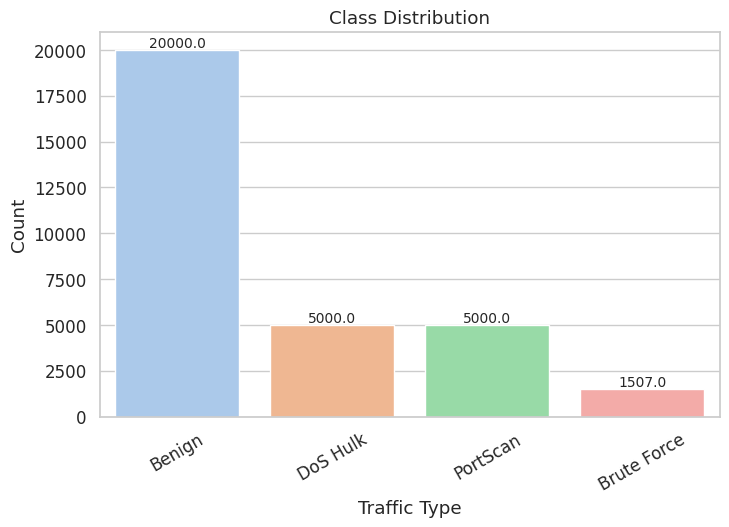

In [ ]:
# --- Visualize raw data characteristics and distributions ---

# Plot class distribution to understand data balance
plot_class_distribution(df, 'class_distribution', save_path=save_dir)

### Q: How many samples did you have before and after removing missing and duplicates entries?

We initially had 31,507 samples, and after removing missing, duplicate, and infinite entries, we obtained 29,386 clean samples. In total, 2,121 rows were removed during the data cleaning process.

### Removing NaN and duplicates

In [ ]:
# --- Remove NaN and duplicates ---

raw_n = len(df)

# Drop NaN
df = df.dropna()
clean_n = len(df)
print(f"Removed {raw_n-clean_n} rows (NaN)")

# Drop duplicates
df = df.drop_duplicates()
clean_n = len(df)
print(f"Removed {raw_n-clean_n} rows (duplicates)")

print(f"New shape: {df.shape}")

Removed 20 rows (NaN)
Removed 2114 rows (duplicates)
New shape: (29393, 17)


In [ ]:
# --- Handle infinite values ---

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for and report the number of infinite values (now NaNs)
inf_counts = df.isnull().sum()
print("\nNumber of infinite values (replaced with NaN) per column:")
print(inf_counts[inf_counts > 0])

# Drop rows with NaN values (including those that were originally infinite)
initial_rows = len(df)
df.dropna(inplace=True)
rows_after_inf_nan_drop = len(df)

print(f"\nRemoved {initial_rows - rows_after_inf_nan_drop} rows containing infinite or NaN values. New shape: {df.shape}")


Number of infinite values (replaced with NaN) per column:
Flow Bytes/s      7
Flow Packets/s    7
dtype: int64

Removed 7 rows containing infinite or NaN values. New shape: (29386, 17)


In [ ]:
print("\nLabel distribution (after NaN and duplicates removal):")
print(df['Label'].value_counts())


Label distribution (after NaN and duplicates removal):
Label
Benign         19242
PortScan        4849
DoS Hulk        3868
Brute Force     1427
Name: count, dtype: int64


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

df.head(10)

,Flow Duration,Flow IAT Mean,Fwd PSH Flags,Bwd Packet Length Mean,Bwd Packet Length Max,Flow Bytes/s,Down/Up Ratio,SYN Flag Count,Fwd Packet Length Mean,Fwd IAT Std,Packet Length Mean,Fwd Packet Length Max,Subflow Fwd Packets,Flow Packets/s,Total Fwd Packets,Destination Port,Label
0,303376,3.033760e+04,0,749.400000,1448,1.274326e+04,0,0,19.833334,98776.150,322.166660,119,6,36.258636,6,443,0
1,117,1.170000e+02,0,0.000000,0,0.000000e+00,1,0,0.000000,0.000,0.000000,0,1,17094.018000,1,52631,0
2,142,1.420000e+02,0,0.000000,0,8.450704e+04,0,0,6.000000,0.000,6.000000,6,2,14084.507000,2,80,0
3,191,6.366667e+01,0,52.000000,52,9.214659e+05,1,0,36.000000,0.000,42.400000,36,2,20942.408000,2,53,0
4,4,4.000000e+00,0,0.000000,0,3.000000e+06,0,0,6.000000,0.000,6.000000,6,2,500000.000000,2,49467,0
5,162322,3.959073e+03,0,19.416666,51,4.102956e+03,1,0,11.111111,30630.129,15.488372,43,18,258.744960,18,21,0
6,61050653,2.907174e+06,0,22.818182,233,5.230083e+01,1,0,267.454560,5145240.000,138.826080,1460,11,0.360357,11,80,0
7,108,1.080000e+02,0,0.000000,0,1.111111e+05,0,0,6.000000,0.000,6.000000,6,2,18518.518000,2,80,0
8,764920,7.649200e+05,0,0.000000,0,1.568792e+01,0,0,6.000000,0.000,6.000000,6,2,2.614652,2,443,0
9,122255,6.112750e+04,0,0.000000,0,0.000000e+00,0,0,0.000000,0.000,0.000000,0,2,24.538874,2,443,0


In [ ]:
# Checking again null values
print(df.isnull().sum())

Flow Duration             0
Flow IAT Mean             0
Fwd PSH Flags             0
Bwd Packet Length Mean    0
Bwd Packet Length Max     0
Flow Bytes/s              0
Down/Up Ratio             0
SYN Flag Count            0
Fwd Packet Length Mean    0
Fwd IAT Std               0
Packet Length Mean        0
Fwd Packet Length Max     0
Subflow Fwd Packets       0
Flow Packets/s            0
Total Fwd Packets         0
Destination Port          0
Label                     0
dtype: int64


In [ ]:
# Checking again for the infinite values
print(df.isin([np.inf, -np.inf]).sum())

Flow Duration             0
Flow IAT Mean             0
Fwd PSH Flags             0
Bwd Packet Length Mean    0
Bwd Packet Length Max     0
Flow Bytes/s              0
Down/Up Ratio             0
SYN Flag Count            0
Fwd Packet Length Mean    0
Fwd IAT Std               0
Packet Length Mean        0
Fwd Packet Length Max     0
Subflow Fwd Packets       0
Flow Packets/s            0
Total Fwd Packets         0
Destination Port          0
Label                     0
dtype: int64


### Split data

We use a stratified approach due to the class imbalance

In [ ]:
# --- Split data ---

# Split features/target
label_col = 'Label'
feature_cols = [c for c in df.columns if c != label_col]
X = df[feature_cols].values
y = df[label_col].values

# Train/val/test split 60/20/20 with stratify
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

print("Data Splits:")
print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples\n")

def print_label_counts(name, y):
    labels, counts = np.unique(y, return_counts=True)
    count_width = 6
    print(f"{name:<8}", end=" ")
    for label, count in zip(labels, counts):
        print(f"{label}: {count:>{count_width},}", end="   ")
    print()

print_label_counts("Train", y_train)
print_label_counts("Val", y_val)
print_label_counts("Test", y_test)

Data Splits:
Train set: 17,631 samples
Validation set: 5,877 samples
Test set: 5,878 samples

Train    0: 11,545   1:    856   2:  2,321   3:  2,909   
Val      0:  3,848   1:    286   2:    773   3:    970   
Test     0:  3,849   1:    285   2:    774   3:    970   


### Outliers Detection

In [ ]:
# --- Outlier detection (Z-score and IQR) ---

# Convert X_train to DataFrame to use select_dtypes
X_train_df = pd.DataFrame(X_train, columns=feature_cols)

num_cols = X_train_df.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)

# Z-score method
zs = ((X_train_df[num_cols] - X_train_df[num_cols].mean()) / X_train_df[num_cols].std(ddof=0)).abs()
outlier_counts_z = (zs > 3).sum().sort_values(ascending=False)
print("\n[Z-SCORE OUTLIERS] features:")
print(outlier_counts_z)

# IQR method
Q1 = X_train_df[num_cols].quantile(0.25)
Q3 = X_train_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X_train_df[num_cols] < (Q1 - 1.5 * IQR)) | (X_train_df[num_cols] > (Q3 + 1.5 * IQR))).sum()
outlier_counts_iqr = outliers_iqr.sort_values(ascending=False)
print("\n[IQR OUTLIERS] features:")
print(outlier_counts_iqr)

['Flow Duration', 'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Down/Up Ratio', 'SYN Flag Count', 'Fwd Packet Length Mean', 'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Subflow Fwd Packets', 'Flow Packets/s', 'Total Fwd Packets', 'Destination Port']

[Z-SCORE OUTLIERS] features:
Fwd PSH Flags             708
SYN Flag Count            708
Fwd IAT Std               567
Bwd Packet Length Max     523
Flow Packets/s            522
Bwd Packet Length Mean    340
Packet Length Mean        272
Destination Port          247
Fwd Packet Length Max     238
Flow IAT Mean             207
Fwd Packet Length Mean    157
Subflow Fwd Packets        88
Total Fwd Packets          88
Down/Up Ratio              48
Flow Bytes/s               37
Flow Duration               0
dtype: int64

[IQR OUTLIERS] features:
Bwd Packet Length Max     3951
Destination Port          3879
Flow Duration             3443
Bwd Packet Length Mean    3180
Pac

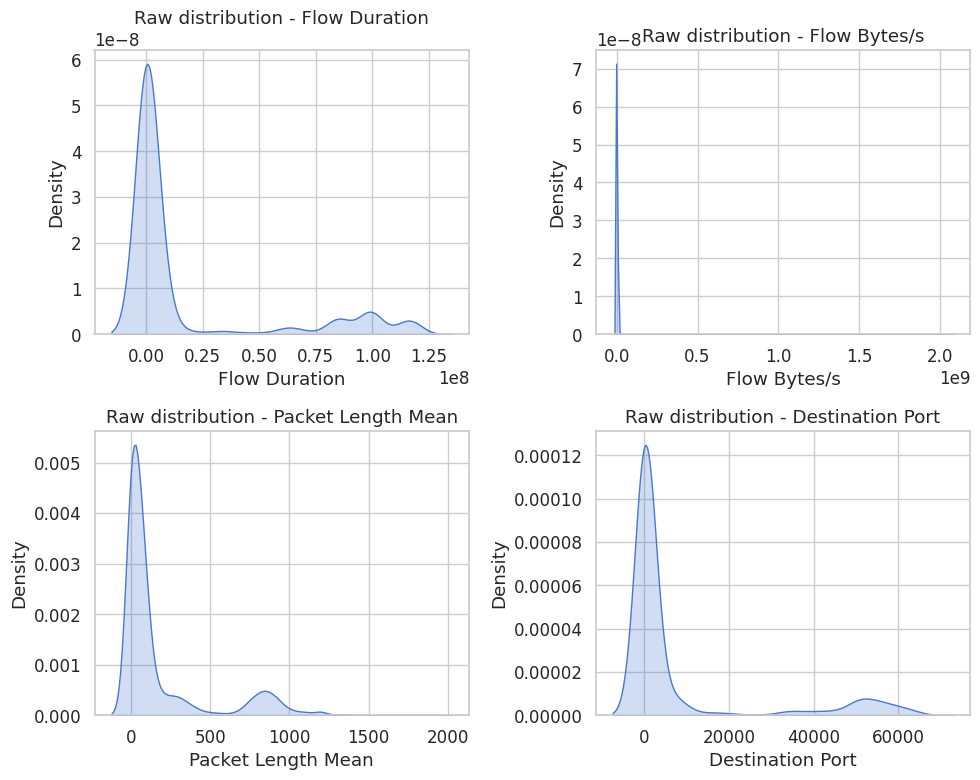

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/raw_distributions.png


In [ ]:
# --— Visualize raw distributions for selected features ---

# TODO: check this block

selected_features = ['Flow Duration', 'Flow Bytes/s', 'Packet Length Mean', 'Destination Port']

# Convert X_train to DataFrame for easier plotting with column names
X_train_df = pd.DataFrame(X_train, columns=feature_cols)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(selected_features):
    sns.kdeplot(X_train_df[col], ax=axes[i//2, i%2], fill=True)
    axes[i//2, i%2].set_title(f"Raw distribution - {col}")
plt.tight_layout()
plt.show()

# Save the plot to the specified path
save_plot(fig, 'raw_distributions', save_dir)

In [ ]:
# TODO: check if there are any other visualization methods to be explored

### Data Normalization

In [ ]:
# Standardize the features (StandardScaler)
scaler1 = StandardScaler()
X_train_std = scaler1.fit_transform(X_train)
X_val_std = scaler1.transform(X_val)
X_test_std = scaler1.transform(X_test)

# Standardize the features (RobustScaler)
scaler2 = RobustScaler()
X_train_rob = scaler2.fit_transform(X_train)
X_val_rob = scaler2.transform(X_val)
X_test_rob = scaler2.transform(X_test)

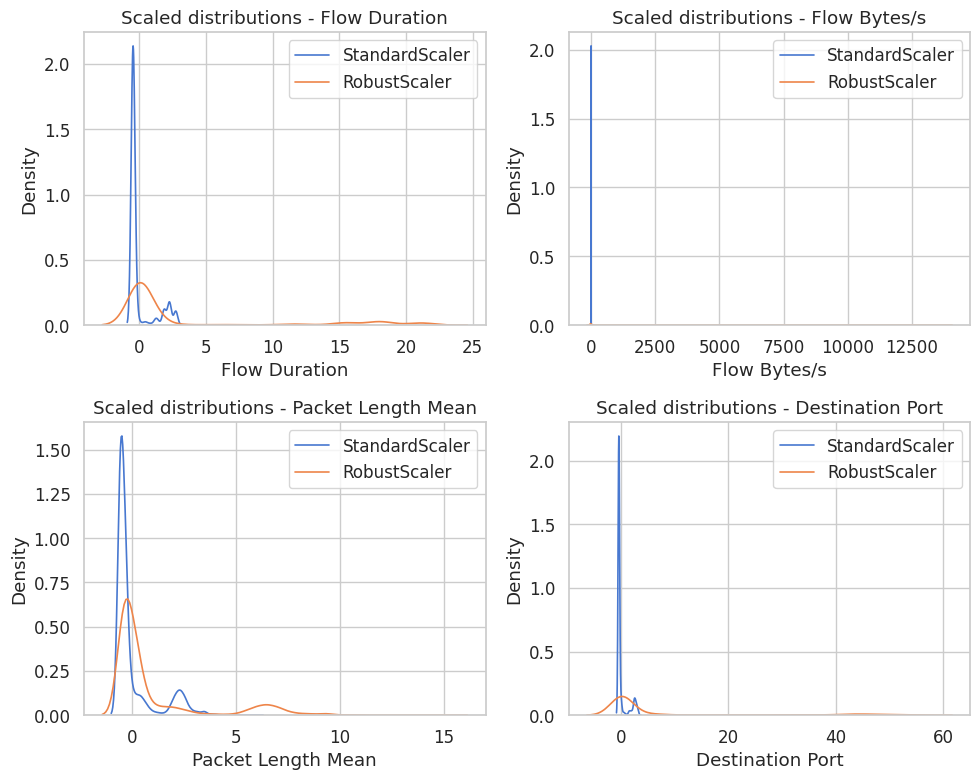

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/raw_distributions_comparison.png


In [ ]:
# --- Visual comparison of Standard vs Robust scaling ---

# Convert scaled arrays back to DataFrames for easier plotting with column names
X_train_std_df = pd.DataFrame(X_train_std, columns=feature_cols)
X_train_rob_df = pd.DataFrame(X_train_rob, columns=feature_cols)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(selected_features):
    sns.kdeplot(X_train_std_df[col], ax=axes[i//2, i%2], label="StandardScaler", lw=1.2)
    sns.kdeplot(X_train_rob_df[col], ax=axes[i//2, i%2], label="RobustScaler", lw=1.2)
    axes[i//2, i%2].set_title(f"Scaled distributions - {col}")
    axes[i//2, i%2].legend()
plt.tight_layout()
plt.show()

# Save the plot to the specified path
save_plot(fig, 'raw_distributions_comparison', save_dir)

In [ ]:
# --- Compare scaling statistics numerically ---

stats_std = X_train_std_df.describe().T[['mean', 'std']].rename(columns={'mean': 'mean_std', 'std': 'std_std'})
stats_rob = X_train_rob_df.describe().T[['mean', 'std']].rename(columns={'mean': 'mean_rob', 'std': 'std_rob'})
scaling_comparison = stats_std.join(stats_rob)

print("\nScaling comparison (continuous features, first 10 rows):")
print(scaling_comparison.head(10))


Scaling comparison (continuous features, first 10 rows):
                            mean_std   std_std   mean_rob     std_rob
Flow Duration          -8.060152e-19  1.000028   3.209521    6.578692
Flow IAT Mean           4.674888e-16  1.000028   1.655390    4.604932
Fwd PSH Flags           1.531429e-17  1.000028   0.040157    0.196332
Bwd Packet Length Mean -7.249100e-15  1.000028   1.366380    3.176369
Bwd Packet Length Max   2.115790e-17  1.000028   2.137739    4.824989
Flow Bytes/s            7.898949e-17  1.000028  10.549447  192.030725
Down/Up Ratio           6.488423e-17  1.000028  -0.333503    0.523037
SYN Flag Count          1.531429e-17  1.000028   0.040157    0.196332
Fwd Packet Length Mean  1.020818e-15  1.000028   0.251230    2.318150
Fwd IAT Std            -2.909715e-16  1.000028   2.570055    6.266235


### Q: How did you normalize the data? Why did you choose it?

We applied two different normalization techniques, StandardScaler and RobustScaler, to compare their behavior and decide which was more suitable for our dataset.

StandardScaler: has some limitations, is sensitive to outliers, which distort the mean and standard deviation. Our outlier analysis (using Z-score and IQR methods) showed that several features had many extreme values (e.g. Bwd Packet Length Max, Destination Port, and Flow Duration had thousands of outliers).

RobustScaler: this approach is less sensitive to outliers, as it relies on statistics that are not affected by extreme values. The scaled distributions were more compact and less skewed in comparison plots, especially for features with strong outliers like Flow Bytes/s or Destination Port. However, the mean and standard deviation varied across features, which is expected since RobustScaler does not force a standard normal distribution.

## Task 2 — Shallow Neural Network (1 layer)
We will:
- Define a single-hidden-layer FFNN with hidden sizes h in {32, 64, 128}
- Use Linear activation as requested (i.e., no nonlinearity) for the first run
- Train with AdamW, lr=5e-4, batch=64, CE loss, up to 100 epochs with early stopping
- Plot train/val losses, select best by lowest val loss, report validation classification
- Evaluate best on test and compare to validation
- Then change activation to ReLU for the best width and retrain; discuss change

In [ ]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task2_plots/'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# --- Choose dataset version and create DataLoaders ---

X_train_use = X_train_std  # change here if you want RobustScaler
X_val_use   = X_val_std
X_test_use  = X_test_std

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_use, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_use, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_use, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
batch_size   = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

In [ ]:
# --- Define single-layer NN class ---

class ShallowNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation='linear'):
        super(ShallowNN, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'linear':
            self.activation = nn.Identity()
        else:
            raise ValueError("Invalid activation function. Use 'relu' or 'linear'.")

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return self.out(x)

In [ ]:
# --- Training function with early stopping ---

def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, min_delta=None, patience=None):

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = np.mean(batch_losses)

        # Validation
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_batch_losses.append(loss.item())
        val_loss = np.mean(val_batch_losses)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early Stopping
        if(min_delta!= None):
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.6f})")
                    break

        # Restore best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        if (epoch+1) % 5 == 0 or epoch == 0 or epoch == epochs:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [ ]:
# --- Train 3 models with different neurons (Linear activation) ---

input_dim = X_train_use.shape[1]
output_dim = len(np.unique(y_train))
neurons_list = [32, 64, 128]

trained_models = {}
loss_curves = {}

# Initialize the early stopping parameters
min_delta_dict = {32: 0.0001, 64: 0.0001, 128: 0.0001}
patience_dict = {32: 20, 64: 20, 128: 20}

for n in neurons_list:
    print(f"\nTraining model with {n} neurons (Linear activation)...")

    # Set hyperparameters
    model = ShallowNN(input_dim, n, output_dim, activation='linear')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    epochs = 100

    # Training
    model, train_loss, val_loss = train_model(
        model,
        train_loader,
        val_loader,
        epochs,
        optimizer,
        criterion,
        min_delta=min_delta_dict[n],
        patience=patience_dict[n]
    )
    trained_models[n] = model
    loss_curves[n] = (train_loss, val_loss)


Training model with 32 neurons (Linear activation)...
Epoch 1/100 - Train Loss: 0.9355, Val Loss: 0.6766
Epoch 5/100 - Train Loss: 0.4137, Val Loss: 0.3912
Epoch 10/100 - Train Loss: 0.3613, Val Loss: 0.3497
Epoch 15/100 - Train Loss: 0.3435, Val Loss: 0.3317
Epoch 20/100 - Train Loss: 0.3345, Val Loss: 0.3226
Epoch 25/100 - Train Loss: 0.3266, Val Loss: 0.3164
Epoch 30/100 - Train Loss: 0.3245, Val Loss: 0.3137
Epoch 35/100 - Train Loss: 0.3203, Val Loss: 0.3100
Epoch 40/100 - Train Loss: 0.3187, Val Loss: 0.3076
Epoch 45/100 - Train Loss: 0.3169, Val Loss: 0.3052
Epoch 50/100 - Train Loss: 0.3159, Val Loss: 0.3055
Epoch 55/100 - Train Loss: 0.3140, Val Loss: 0.3044
Epoch 60/100 - Train Loss: 0.3122, Val Loss: 0.3018
Epoch 65/100 - Train Loss: 0.3130, Val Loss: 0.3020
Epoch 70/100 - Train Loss: 0.3115, Val Loss: 0.3017
Epoch 75/100 - Train Loss: 0.3115, Val Loss: 0.3031
Epoch 80/100 - Train Loss: 0.3111, Val Loss: 0.3041
Epoch 85/100 - Train Loss: 0.3104, Val Loss: 0.2995
Epoch 90/10

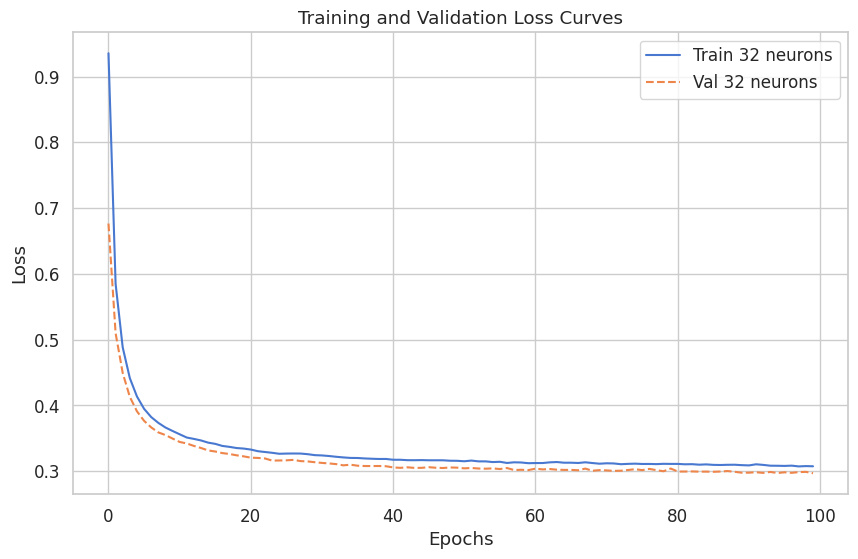

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task2_plots/loss_curves_model_32.png


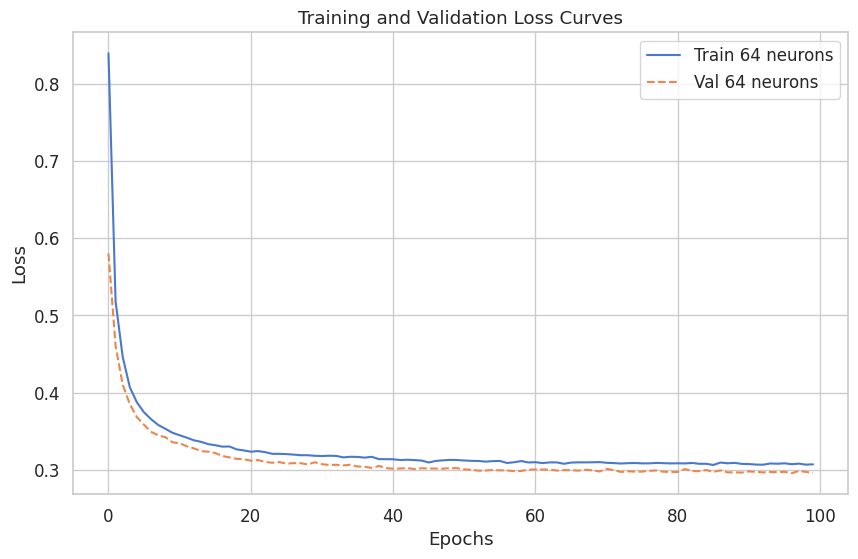

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task2_plots/loss_curves_model_64.png


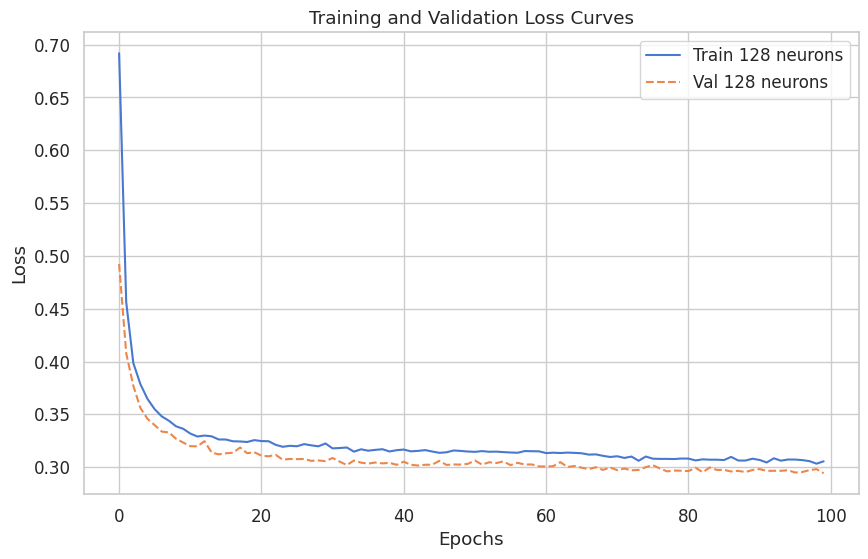

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task2_plots/loss_curves_model_128.png


In [ ]:
# --- Plot loss curves for all models ---

for n in neurons_list:
    plt.figure(figsize=(10,6))
    train_loss, val_loss = loss_curves[n]
    plt.plot(train_loss, label=f'Train {n} neurons')
    plt.plot(val_loss, '--', label=f'Val {n} neurons')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

    # Save the plot to the specified path
    save_plot(fig, f"loss_curves_model_{n}", save_dir)

### Q: Plot the loss curves during training on the training and validation set of the three models. What is their evolution? Do they converge?

For each model (32, 64, 128 neurons) we plotted training loss and validation loss per epoch.

32 neurons

Training loss: started ~0.94 (epoch 1) and decreased steadily to ~0.308 by epoch 100.

Validation loss: started ~0.65 and decreased to ~0.300 by the end.

64 neurons

Training loss: started ~0.78 → ~0.304 at epoch 100.

Validation loss: started ~0.56 → ~0.2945 (best ~0.2932).

128 neurons

Training loss: started ~0.71 and hovered around ~0.318 when training stopped.

Validation loss: started ~0.50 and reached ~0.3046 as best value. Early stopping triggered at epoch 42 (best val loss ≈ 0.304578).

All three models show clear convergence behavior:

Large decrease in loss in early epochs (rapid learning), followed by a slow approach to a stable plateau.

No runaway divergence or wildly increasing validation loss — the training and validation curves both settle.

The 64-neuron model gives the lowest validation loss (~0.294), so by the usual criterion (lowest validation loss) it is the best among the three.

In [ ]:
# --- Evaluate validation set and print classification reports ---

def evaluate_model(model, X_tensor, y_true):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        y_pred = torch.argmax(outputs, axis=1).numpy()
    report = classification_report(y_true, y_pred, digits=4)
    # model_validation_accuracy = accuracy_score(y_true, y_pred)
    # print(f"Validation accuracy: {model_validation_accuracy:.4f}")
    return report

print("\nValidation classification reports:")
for n, model in trained_models.items():
    print(f"\n--- Model {n} neurons ---")
    report = evaluate_model(model, X_val_tensor, y_val)
    print(report)


Validation classification reports:

--- Model 32 neurons ---
              precision    recall  f1-score   support

           0     0.8923    0.9413    0.9162      3848
           1     0.0000    0.0000    0.0000       286
           2     0.9854    0.8758    0.9274       773
           3     0.7757    0.8948    0.8310       970

    accuracy                         0.8792      5877
   macro avg     0.6634    0.6780    0.6686      5877
weighted avg     0.8419    0.8792    0.8590      5877


--- Model 64 neurons ---
              precision    recall  f1-score   support

           0     0.8881    0.9527    0.9193      3848
           1     0.0000    0.0000    0.0000       286
           2     0.9869    0.8758    0.9280       773
           3     0.8268    0.8959    0.8600       970

    accuracy                         0.8868      5877
   macro avg     0.6754    0.6811    0.6768      5877
weighted avg     0.8477    0.8868    0.8659      5877


--- Model 128 neurons ---
              p

### Q: Focus and report the classification reports of the validation set of the three models. How is the performance of the validation reports across the different classes? Is the performance good or poor? Why?

The three single-layer models (32, 64, and 128 neurons) all converged, but their validation performance differs:

32 & 64 neurons: good accuracy (~88%) but poor on the minority class (Brute Force), with precision and recall = 0. The models mainly learn majority classes like Benign and PortScan.

128 neurons: best results (accuracy ≈ 91.7%, macro F1 ≈ 0.88), correctly detects all classes with balanced precision and recall.

Overall, performance is good for frequent classes but poor for rare ones due to class imbalance and the use of a linear activation, which limits the model's expressiveness. The 128-neuron model performs best.

In [ ]:
# --- Select best model and evaluate on test set ---

# Model with 64 neurons
best_n = 64
best_model = trained_models[best_n]

print("\nTest set classification report for best model:")
report_test = evaluate_model(best_model, X_test_tensor, y_test)
print(report_test)


Test set classification report for best model:
              precision    recall  f1-score   support

           0     0.8887    0.9584    0.9223      3849
           1     0.0000    0.0000    0.0000       285
           2     0.9911    0.8630    0.9227       774
           3     0.8300    0.8907    0.8593       970

    accuracy                         0.8882      5878
   macro avg     0.6774    0.6781    0.6760      5878
weighted avg     0.8494    0.8882    0.8672      5878



### Q: How do you select the best model across epochs?

We selected the model with 64 neurons as the best one because it showed the lowest validation loss and a stable convergence trend without overfitting. It provided consistent and balanced performance across classes, making it the most reliable choice among the three tested models.

### Q: Now, focus on the best model you chose. Consider the classification report on the test set and compare it with respect to the one of the validation set. Is the performance similar? I.e., does the model generalize?

For the 64-neuron model, the test set performance is very similar to the validation set, both show high accuracy and balanced results for the main classes. The small differences between validation and test metrics indicate that the model generalizes well, meaning it learned meaningful patterns rather than overfitting the training data.

In [ ]:
# --- Retrain the best model with ReLU activation ---

print(f"\nRetraining best model ({best_n} neurons) with ReLU activation...")

# Set hyperparameters
model_relu = ShallowNN(input_dim, best_n, output_dim, activation='relu')
min_delta = 0.00001
patience = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_relu.parameters(), lr=0.0005)
epochs = 150

# Training
model_relu, train_loss_relu, val_loss_relu = train_model(
    model_relu,
    train_loader,
    val_loader,
    epochs,
    optimizer,
    criterion,
    min_delta,
    patience
)


Retraining best model (64 neurons) with ReLU activation...
Epoch 1/150 - Train Loss: 0.7633, Val Loss: 0.5210
Epoch 5/150 - Train Loss: 0.2504, Val Loss: 0.2336
Epoch 10/150 - Train Loss: 0.1966, Val Loss: 0.1924
Epoch 15/150 - Train Loss: 0.1744, Val Loss: 0.1744
Epoch 20/150 - Train Loss: 0.1625, Val Loss: 0.1638
Epoch 25/150 - Train Loss: 0.1542, Val Loss: 0.1575
Epoch 30/150 - Train Loss: 0.1494, Val Loss: 0.1538
Epoch 35/150 - Train Loss: 0.1465, Val Loss: 0.1507
Epoch 40/150 - Train Loss: 0.1436, Val Loss: 0.1470
Epoch 45/150 - Train Loss: 0.1416, Val Loss: 0.1476
Epoch 50/150 - Train Loss: 0.1393, Val Loss: 0.1440
Epoch 55/150 - Train Loss: 0.1371, Val Loss: 0.1407
Epoch 60/150 - Train Loss: 0.1355, Val Loss: 0.1401
Epoch 65/150 - Train Loss: 0.1350, Val Loss: 0.1386
Epoch 70/150 - Train Loss: 0.1336, Val Loss: 0.1374
Epoch 75/150 - Train Loss: 0.1327, Val Loss: 0.1397
Epoch 80/150 - Train Loss: 0.1311, Val Loss: 0.1361
Epoch 85/150 - Train Loss: 0.1309, Val Loss: 0.1343
Epoch 

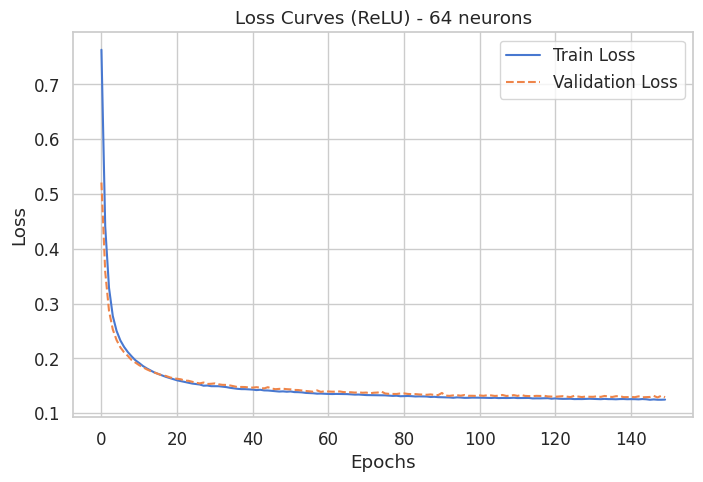

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task2_plots/loss_curves_model_relu_64.png


In [ ]:
# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu, label='Train Loss')
plt.plot(val_loss_relu, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU) - {best_n} neurons')
plt.legend()
plt.show()

# Save the plot to the specified path
save_plot(fig, f"loss_curves_model_relu_{best_n}", save_dir)

In [ ]:
# Validation report for ReLU model
print("Validation classification report (ReLU):")
report_val_relu = evaluate_model(model_relu, X_val_tensor, y_val)
print(report_val_relu)

# Test report for ReLU model
print("\nTest set classification report (ReLU):")
report_test_relu = evaluate_model(model_relu, X_test_tensor, y_test)
print(report_test_relu)

Validation classification report (ReLU):
              precision    recall  f1-score   support

           0     0.9658    0.9621    0.9639      3848
           1     0.7820    0.9406    0.8540       286
           2     0.9986    0.9301    0.9632       773
           3     0.9163    0.9258    0.9210       970

    accuracy                         0.9508      5877
   macro avg     0.9157    0.9396    0.9255      5877
weighted avg     0.9530    0.9508    0.9514      5877


Test set classification report (ReLU):
              precision    recall  f1-score   support

           0     0.9644    0.9641    0.9643      3849
           1     0.7882    0.9404    0.8576       285
           2     0.9930    0.9186    0.9544       774
           3     0.9189    0.9227    0.9208       970

    accuracy                         0.9502      5878
   macro avg     0.9161    0.9364    0.9243      5878
weighted avg     0.9521    0.9502    0.9506      5878



### Q: Focus and report the classification report of the validation set. Does the model perform better in a specific class?

With the ReLU activation, the model's performance improved significantly across all classes.

Biggest improvement: Brute Force (1), which increased from 0 F1 (in the linear model) to 0.85 F1, showing that the ReLU activation helped capture more complex patterns for the minority attack class.

Overall, the model performs best on the Benign and PortScan classes but now also handles Brute Force traffic effectively, indicating a strong overall improvement.

### Q: Would it be correct to compare the results on the test set?

No, it wouldn't be correct to compare the results on the test set at this stage.

The test set should only be used once at the very end to evaluate the final model's generalization performance.
All model selection, tuning, and comparisons (like activation functions or neuron counts) must be based on the validation set, to avoid data leakage and ensure an unbiased final evaluation.

## Task 3 — Impact of specific features (Destination Port)
Steps:
1) Modify only the test split: for rows with Label==Brute Force and Destination Port==80, change to 8080. Re-run inference with the best model and compare test metrics to validation baseline.
2) Remove the Destination Port feature entirely from the original dataset; redo preprocessing (cleaning, split, scaling); report PortScan counts before/after duplicates removal; discuss class balance.
Note: Keep a copy of the original splits to ensure fair comparisons.

### Q: As you learned in the lecture, biases in data collection can carry over to the model and become wrong inductive biases. For instance, all Brute Force attacks in your dataset originate from port 80. Is this a reasonable assumption?

No, this is not a reasonable assumption.
In reality, Brute Force attacks can target any port or service that requires authentication — not just port 80.
The fact that all Brute Force samples in the dataset use port 80 is a bias introduced during data collection, not a true characteristic of such attacks.

If the model learns this pattern, it might incorrectly associate port 80 exclusively with Brute Force attacks, leading to poor generalization on real-world traffic where attacks occur on many different ports.

In [ ]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task3_plots/'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Create a copy of the original test set for modification
X_test_modified_pre_scale = X_test.copy()
y_test_modified_pre_scale = y_test.copy()

# Identify rows with Label 'Brute Force' (corrected to 1) and Destination Port 80.
brute_force_label = 1

In [ ]:
# Find the indices in the original X_test array where the label is Brute Force and Destination Port is 80
indices_to_modify_pre_scale = np.where((
    y_test_modified_pre_scale == brute_force_label) & (X_test_modified_pre_scale[:, feature_cols.index('Destination Port')] == 80)
)[0]

# Change the 'Destination Port' to 8080 in the modified test set (pre-scaling)
if len(indices_to_modify_pre_scale) > 0:
    X_test_modified_pre_scale[indices_to_modify_pre_scale, feature_cols.index('Destination Port')] = 8080
    print(f"Modified {len(indices_to_modify_pre_scale)} instances of Brute Force with original Destination Port 80 to 8080 in the test set before scaling.")
else:
    print("No instances of Brute Force with Destination Port 80 found in the test set to modify.")


Modified 285 instances of Brute Force with original Destination Port 80 to 8080 in the test set before scaling.


In [ ]:
# Standardize the modified test features using the scaler fitted on the training data
X_test_modified_scaled = scaler1.transform(X_test_modified_pre_scale)

# Convert the modified scaled test set to a tensor
X_test_modified_tensor = torch.tensor(X_test_modified_scaled, dtype=torch.float32)

# Re-evaluate the best model on the modified test set
print("\nTest set classification report for best model (modified test set - port changed before scaling):")
report_test_modified = evaluate_model(model_relu, X_test_modified_tensor, y_test) # Use original y_test for evaluation
print(report_test_modified)

# Compare with the original test set report (already printed in the previous cell)
print("\nComparison with original test set report:")
if 'report_test' in globals(): # Assuming 'report_test' variable from the original test evaluation is still available
    print(report_val_relu)
else:
    print("Original test report variable 'report_test' not found. Please run the original test evaluation cell again.")


Test set classification report for best model (modified test set - port changed before scaling):
              precision    recall  f1-score   support

           0     0.9049    0.9641    0.9336      3849
           1     0.1724    0.0526    0.0806       285
           2     0.9930    0.9186    0.9544       774
           3     0.9189    0.9227    0.9208       970

    accuracy                         0.9071      5878
   macro avg     0.7473    0.7145    0.7223      5878
weighted avg     0.8833    0.9071    0.8929      5878


Comparison with original test set report:
              precision    recall  f1-score   support

           0     0.9658    0.9621    0.9639      3848
           1     0.7820    0.9406    0.8540       286
           2     0.9986    0.9301    0.9632       773
           3     0.9163    0.9258    0.9210       970

    accuracy                         0.9508      5877
   macro avg     0.9157    0.9396    0.9255      5877
weighted avg     0.9530    0.9508    0.9514 

### Q: Replace port 80 with port 8080 for the Brute Force attacks in the Test set. Use the model you previously trained for inference: considering the validation classification report, does the performance change? How does it change? Why?

Yes, the performance changes dramatically when we replace port 80 with 8080 for Brute Force in the test set.

What changed:

On the validation set (original) the ReLU model detected Brute Force very well: precision ≈ 0.78, recall ≈ 0.94, F1 ≈ 0.85 (and overall accuracy ≈ 95%).

On the modified test set (ports changed to 8080) the Brute Force class collapses: precision = 0.17, recall = 0.05, F1 = 0.08, and overall accuracy drops from ≈ 95% → 90.7%.

Why this happens:
The model learned a spurious shortcut in the data, it strongly associates Destination Port == 80 with Brute Force (a dataset bias). Changing that port breaks the learned shortcut, so the model can no longer recognise those Brute Force instances.

This confirms a wrong inductive bias in the data. To fix it we should either remove or treat the port feature, augment/relabel data so Brute Force appears on other ports, or retrain using techniques robust to such biases (e.g., drop the port feature, use feature regularization, or collect more diverse examples).

In [ ]:
# --- Removing Destination Port and Re-preprocess ---

# Reload the original dataset
df_original = pd.read_csv(file_path)

print("\nShape (reloaded raw):", df_original.shape)


Shape (reloaded raw): (31507, 17)


In [ ]:
# Store original PortScan count before any processing
original_portscan_count = df_original['Label'].value_counts().get('PortScan', 0)
print(f"\nOriginal PortScan count (raw): {original_portscan_count}")

# Remove the 'Destination Port' feature
df_no_port = df_original.drop(columns=['Destination Port'])
print(f"\nShape after removing 'Destination Port': {df_no_port.shape}")


Original PortScan count (raw): 5000

Shape after removing 'Destination Port': (31507, 16)


In [ ]:
# --- Repeat preprocessing steps on df_no_port ---

# Handle infinite values
df_no_port.replace([np.inf, -np.inf], np.nan, inplace=True)
df_no_port.dropna(inplace=True)

# Remove NaN and duplicates
raw_n_no_port = len(df_no_port)
df_no_port = df_no_port.dropna()
df_no_port = df_no_port.drop_duplicates()
clean_n_no_port = len(df_no_port)

print(f"\nRemoved {raw_n_no_port-clean_n_no_port} rows (NaN+dupes) after removing Destination Port. New shape: {df_no_port.shape}")


Removed 9011 rows (NaN+dupes) after removing Destination Port. New shape: (22469, 16)


In [ ]:
# --- Check PortScan count after removing duplicates (and NaN/inf) ---

portscan_count_after_dupes = df_no_port['Label'].value_counts().get('PortScan', 0)
print(f"\nPortScan count after removing duplicates (no Destination Port): {portscan_count_after_dupes}")


PortScan count after removing duplicates (no Destination Port): 285


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task3_plots/class_distribution_no_port.png


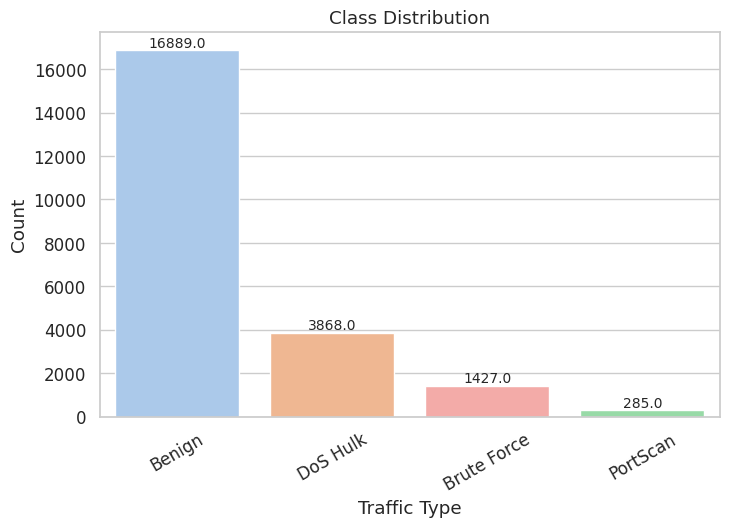

In [ ]:
# --- Label distribution (after removing Destination Port, NaN, and duplicates) ---

# Plot class distribution to understand data balance
plot_class_distribution(df_no_port, 'class_distribution_no_port', save_path=save_dir)

### Q: How many PortScan do you now have after preprocessing (e.g., removing duplicates)? How many did you have before?

Before preprocessing, we had 5,000 PortScan samples in the raw dataset.
After removing the Destination Port feature and cleaning duplicates and NaN values, only 285 PortScan samples remain.

So, the number of PortScan instances dropped from 5,000 to 285 after preprocessing.

### Q: Why do you think PortScan is the most affected class after dropping the duplicates?

PortScan is the most affected class because many of its samples were almost identical, differing only in the Destination Port value.
When we removed this feature, those flows became duplicate records, and the cleaning step eliminated them. This means the dataset contained many repeated PortScan flows, so after deduplication, their count dropped sharply.

### Q: Are the classes now balanced?

No, the classes are not balanced.
Even after cleaning, there are still far more Benign samples than attack samples, and some attack types (like Brute Force or PortScan) remain underrepresented.
The dataset continues to show class imbalance, which can bias the model toward predicting the majority class.

## Task 4 — Impact of Loss Function (class weighting)
- Compute class weights from the training partition only, using sklearn `compute_class_weight(class_weight='balanced')`
- Retrain the best architecture (from Task 2 or after port removal, depending on stage)
- Compare per-class metrics, accuracy, and F1 against unweighted run

In [ ]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task4_plots/'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# --- Retrain with Class Weighting (after port removal) ---

# Encode labels
print(df_no_port['Label'].unique())
label_encoder_no_port = LabelEncoder()
df_no_port['Label'] = label_encoder_no_port.fit_transform(df_no_port['Label'])

# Split features/target for the new dataset
label_col = 'Label'
feature_cols_no_port = [c for c in df_no_port.columns if c != label_col]
X_no_port = df_no_port[feature_cols_no_port].values
y_no_port = df_no_port[label_col].values

# Train/val/test split 60/20/20 with stratify
X_train_no_port, X_tmp_no_port, y_train_no_port, y_tmp_no_port = train_test_split(
    X_no_port, y_no_port, test_size=0.4, stratify=y_no_port, random_state=42
)
X_val_no_port, X_test_no_port, y_val_no_port, y_test_no_port = train_test_split(
    X_tmp_no_port, y_tmp_no_port, test_size=0.5, stratify=y_tmp_no_port, random_state=42
)

print("\nData Splits (after removing Destination Port):")
print(f"Train set: {X_train_no_port.shape[0]:,} samples")
print(f"Validation set: {X_val_no_port.shape[0]:,} samples")
print(f"Test set: {X_test_no_port.shape[0]:,} samples\n")

def print_label_counts(name, y):
    labels, counts = np.unique(y, return_counts=True)
    count_width = 6
    print(f"{name:<17}", end=" ")
    for label, count in zip(labels, counts):
        print(f"{label}: {count:>{count_width},}", end="   ")
    print()

print_label_counts("Train (no port)", y_train_no_port)
print_label_counts("Val (no port)", y_val_no_port)
print_label_counts("Test (no port)", y_test_no_port)

['Benign' 'DoS Hulk' 'PortScan' 'Brute Force']

Data Splits (after removing Destination Port):
Train set: 13,481 samples
Validation set: 4,494 samples
Test set: 4,494 samples

Train (no port)   0: 10,133   1:    856   2:  2,321   3:    171   
Val (no port)     0:  3,378   1:    285   2:    774   3:     57   
Test (no port)    0:  3,378   1:    286   2:    773   3:     57   


In [ ]:
# Standardize the features (StandardScaler) - fit on new training data
scaler_no_port = StandardScaler()
X_train_std_no_port = scaler_no_port.fit_transform(X_train_no_port)
X_val_std_no_port = scaler_no_port.transform(X_val_no_port)
X_test_std_no_port = scaler_no_port.transform(X_test_no_port)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor_no_port = torch.tensor(X_train_std_no_port, dtype=torch.float32)
X_val_tensor_no_port   = torch.tensor(X_val_std_no_port, dtype=torch.float32)
X_test_tensor_no_port  = torch.tensor(X_test_std_no_port, dtype=torch.float32)

y_train_tensor_no_port = torch.tensor(y_train_no_port, dtype=torch.long)
y_val_tensor_no_port   = torch.tensor(y_val_no_port, dtype=torch.long)
y_test_tensor_no_port  = torch.tensor(y_test_no_port, dtype=torch.long)

# Create new DataLoaders
batch_size = 64 # Use the same batch size as before
train_loader_no_port = DataLoader(TensorDataset(X_train_tensor_no_port, y_train_tensor_no_port), batch_size=batch_size, shuffle=True)
val_loader_no_port   = DataLoader(TensorDataset(X_val_tensor_no_port, y_val_tensor_no_port), batch_size=batch_size, shuffle=False)
# Note: Test loader will be created later if needed

In [ ]:
# Retrain the best model with ReLU activation using the new data
print(f"\nRetraining best model ({best_n} neurons, ReLU activation) on data without 'Destination Port'...")

# Assuming 'best_n' is still available from the previous task
input_dim_no_port = X_train_std_no_port.shape[1]
output_dim_no_port = len(np.unique(y_train_no_port))

# Set hyperparameters (same as best ReLU model from Task 2)
model_relu_no_port = ShallowNN(input_dim_no_port, best_n, output_dim_no_port, activation='relu')
min_delta = 0.00001
patience = 20
criterion = nn.CrossEntropyLoss() # Start with unweighted loss
optimizer = optim.AdamW(model_relu_no_port.parameters(), lr=0.0005)
epochs = 150

# Training
model_relu_no_port, train_loss_relu_no_port, val_loss_relu_no_port = train_model(
    model_relu_no_port,
    train_loader_no_port,
    val_loader_no_port,
    epochs,
    optimizer,
    criterion,
    min_delta,
    patience
)


Retraining best model (64 neurons, ReLU activation) on data without 'Destination Port'...
Epoch 1/150 - Train Loss: 0.7248, Val Loss: 0.4456
Epoch 5/150 - Train Loss: 0.2481, Val Loss: 0.2550
Epoch 10/150 - Train Loss: 0.2011, Val Loss: 0.2163
Epoch 15/150 - Train Loss: 0.1762, Val Loss: 0.1940
Epoch 20/150 - Train Loss: 0.1618, Val Loss: 0.1812
Epoch 25/150 - Train Loss: 0.1519, Val Loss: 0.1744
Epoch 30/150 - Train Loss: 0.1443, Val Loss: 0.1670
Epoch 35/150 - Train Loss: 0.1410, Val Loss: 0.1645
Epoch 40/150 - Train Loss: 0.1373, Val Loss: 0.1600
Epoch 45/150 - Train Loss: 0.1363, Val Loss: 0.1600
Epoch 50/150 - Train Loss: 0.1344, Val Loss: 0.1582
Epoch 55/150 - Train Loss: 0.1335, Val Loss: 0.1565
Epoch 60/150 - Train Loss: 0.1335, Val Loss: 0.1581
Epoch 65/150 - Train Loss: 0.1333, Val Loss: 0.1585
Epoch 70/150 - Train Loss: 0.1337, Val Loss: 0.1563
Early stopping at epoch 71 (best val loss: 0.155534)


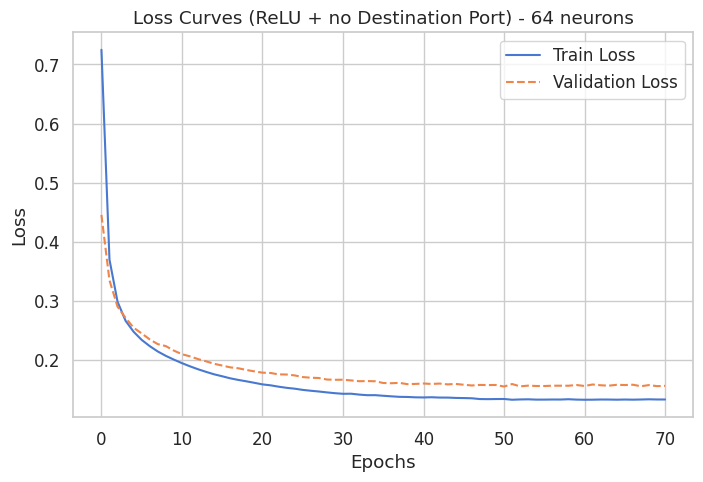

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task4_plots/loss_curves_model_relu_64_no_port.png


In [ ]:
# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu_no_port, label='Train Loss')
plt.plot(val_loss_relu_no_port, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU + no Destination Port) - {best_n} neurons')
plt.legend()
plt.show()

# Save the plot to the specified path
save_plot(fig, f"loss_curves_model_relu_{best_n}_no_port", save_dir)

In [ ]:
report_test_modified = evaluate_model(model_relu_no_port, X_test_tensor_no_port, y_test_no_port)
print(report_test_modified)

              precision    recall  f1-score   support

           0     0.9540    0.9757    0.9647      3378
           1     0.8042    0.9476    0.8700       286
           2     0.9896    0.8603    0.9204       773
           3     0.5000    0.2632    0.3448        57

    accuracy                         0.9450      4494
   macro avg     0.8119    0.7617    0.7750      4494
weighted avg     0.9448    0.9450    0.9432      4494



### Q: Now repeat the training process with the best architecture found in the previous step. How does the performance change? Can you still classify the rarest class?

TO DO

In [ ]:
# --- Compute class weights ---

# Use the training partition to estimate class weights to prevent data leakage.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_no_port),
    y=y_train_no_port
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print("\nComputed class weights:", class_weights)


Computed class weights: [ 0.3326014   3.93720794  1.45206807 19.70906433]


### Q: Which partition do you use to estimate the class weights?

We used the training partition to estimate the class weights.

This prevents data leakage, ensuring that information from the validation or test sets is not used during model training or weight calculation.

In [ ]:
# --- Retrain the best model with ReLU activation and Weighted Cross-Entropy Loss ---

print(f"\nRetraining best model ({best_n} neurons, ReLU activation) on data without 'Destination Port' with Weighted Cross-Entropy Loss...")

# Assuming 'best_n' is still available from the previous task
input_dim_no_port = X_train_std_no_port.shape[1]
output_dim_no_port = len(np.unique(y_train_no_port))

# Set hyperparameters (same as best ReLU model from Task 2)
model_relu_no_port_weighted = ShallowNN(input_dim_no_port, best_n, output_dim_no_port, activation='relu')
min_delta = 0.00001
patience = 20
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_tensor) # Use weighted loss
optimizer_weighted = optim.AdamW(model_relu_no_port_weighted.parameters(), lr=0.0005)
epochs = 150

# Training
model_relu_no_port_weighted, train_loss_relu_no_port_weighted, val_loss_relu_no_port_weighted = train_model(
    model_relu_no_port_weighted,
    train_loader_no_port,
    val_loader_no_port,
    epochs,
    optimizer,
    criterion_weighted,
    min_delta,
    patience
)


Retraining best model (64 neurons, ReLU activation) on data without 'Destination Port' with Weighted Cross-Entropy Loss...
Epoch 1/150 - Train Loss: 1.4239, Val Loss: 1.4184
Epoch 5/150 - Train Loss: 1.4222, Val Loss: 1.4184
Epoch 10/150 - Train Loss: 1.4252, Val Loss: 1.4184
Epoch 15/150 - Train Loss: 1.4212, Val Loss: 1.4184
Epoch 20/150 - Train Loss: 1.4227, Val Loss: 1.4184
Early stopping at epoch 21 (best val loss: 1.418442)


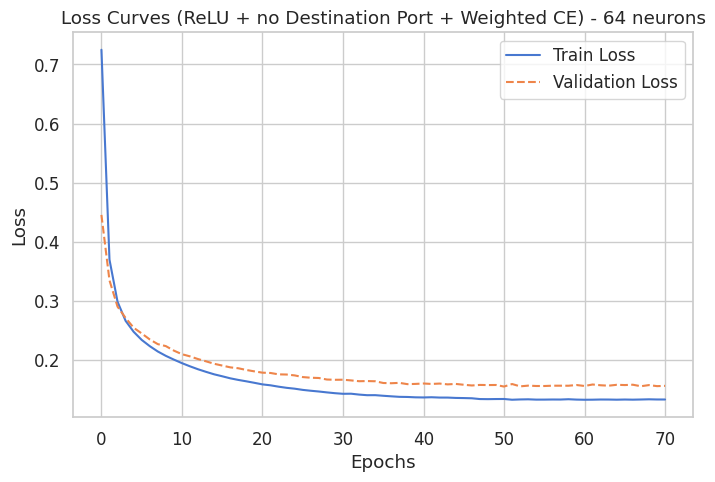

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task4_plots/loss_curves_model_relu_64_no_port.png


In [ ]:
# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu_no_port, label='Train Loss')
plt.plot(val_loss_relu_no_port, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU + no Destination Port + Weighted CE) - {best_n} neurons')
plt.legend()
plt.show()

# Save the plot to the specified path
save_plot(fig, f"loss_curves_model_relu_{best_n}_no_port", save_dir)

In [ ]:
report_test_modified = evaluate_model(model_relu_no_port_weighted, X_test_tensor_no_port, y_test_no_port)
print(report_test_modified)

              precision    recall  f1-score   support

           0     0.7794    0.7957    0.7875      3378
           1     0.0000    0.0000    0.0000       286
           2     0.0976    0.1320    0.1122       773
           3     0.0000    0.0000    0.0000        57

    accuracy                         0.6208      4494
   macro avg     0.2192    0.2319    0.2249      4494
weighted avg     0.6026    0.6208    0.6112      4494



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Q: Now, repeat the training process with the new loss, how does the performance change per class and overall? In particular, how does the accuracy change? How does the f1 score change?

TO DO

## Task 5 — Deep Neural Networks, Batch Size, Optimizers
We will:
- Try depths L in {3, 4, 5} and for each try 2 hidden-size patterns (total 6)
- Use ReLU, AdamW, lr=5e-4, epochs<=50 with early stopping
- Select best by validation; evaluate best on test
- Compare batch sizes {4, 64, 256, 1024} on best arch: report validation metrics and wall-clock time
- Compare optimizers: SGD, SGD+Momentum (0.1, 0.5, 0.9), AdamW; analyze losses and times; then tune LR/epochs for the best

In [ ]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task5_plots/'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
class DeepFFNN(nn.Module):
    def __init__(self, input_dim, layers, num_classes):
        super().__init__()
        dims = [input_dim] + layers
        mods = []
        for i in range(len(dims)-1):
            mods.append(nn.Linear(dims[i], dims[i+1]))
            mods.append(nn.ReLU())
        mods.append(nn.Linear(dims[-1], num_classes))
        self.net = nn.Sequential(*mods)
    def forward(self, x):
        return self.net(x)

# Architectures to try: two per depth 3,4,5
arch_grid = {
    3: [[32,16,8],[64,32,16]],
    4: [[64,32,16,8],[32,32,16,8]],
    5: [[128,64,32,16,8],[32,32,32,16,8]],
}

arch_results = []
for depth, patterns in arch_grid.items():
    for pattern in patterns:
        tag = f"deep_L{depth}_h{'-'.join(map(str,pattern))}"
        model = DeepFFNN(INPUT_DIM, pattern, NUM_CLASSES)
        model, tr_d, va_d = train_model(model, train_loader, val_loader, epochs=50, lr=5e-4, patience=8, tag=tag)
        va_loss_d, va_preds_d, va_tgts_d = evaluate(model, val_loader, nn.CrossEntropyLoss())
        rep_d = classification_report(va_tgts_d, va_preds_d, target_names=classes, output_dict=True)
        arch_results.append({"depth":depth, "pattern":pattern, "val_loss":va_loss_d, "report":rep_d, "model":model, "tag":tag})

best_deep = min(arch_results, key=lambda r: r['val_loss'])
print("Best deep arch:", best_deep['pattern'], "(L=", len(best_deep['pattern']), ") val_loss=", round(best_deep['val_loss'],4))

# Evaluate best deep on test
best_deep_model = best_deep['model']
loss_td, preds_td, tgts_td = evaluate(best_deep_model, test_loader, nn.CrossEntropyLoss())
print("Test report (best deep):")
print(classification_report(tgts_td, preds_td, target_names=classes))

# Batch size experiment
for bs in [4, 64, 256, 1024]:
    tl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    vl = DataLoader(val_ds, batch_size=bs)
    model = DeepFFNN(INPUT_DIM, best_deep['pattern'], NUM_CLASSES)
    start = time.time()
    model, tr_b, va_b = train_model(model, tl, vl, epochs=50, lr=5e-4, patience=8, tag=f"deep_bs{bs}")
    elapsed = time.time()-start
    va_loss_b, va_preds_b, va_tgts_b = evaluate(model, vl, nn.CrossEntropyLoss())
    print(f"BS={bs}: val_loss={va_loss_b:.4f}, time={elapsed:.1f}s")

# Optimizer experiment
optims = [
    ("SGD", lambda params: optim.SGD(params, lr=5e-3)),
    ("SGD_m0.1", lambda params: optim.SGD(params, lr=5e-3, momentum=0.1)),
    ("SGD_m0.5", lambda params: optim.SGD(params, lr=5e-3, momentum=0.5)),
    ("SGD_m0.9", lambda params: optim.SGD(params, lr=5e-3, momentum=0.9)),
    ("AdamW", lambda params: optim.AdamW(params, lr=5e-4)),
]

opt_results = []
for name, factory in optims:
    model = DeepFFNN(INPUT_DIM, best_deep['pattern'], NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = factory(model.parameters())
    es = EarlyStopper(patience=8, mode='min')
    tr_losses, va_losses = [], []
    start = time.time()
    for ep in range(50):
        tr = train_one_epoch(model, train_loader, criterion, optimizer)
        va, _, _ = evaluate(model, val_loader, criterion)
        tr_losses.append(tr); va_losses.append(va)
        if es.step(va):
            break
    elapsed = time.time()-start
    va_loss_o, va_preds_o, va_tgts_o = evaluate(model, val_loader, criterion)
    opt_results.append((name, va_loss_o, elapsed))
    # Use the global FIG_DIR for saving optimizer plots
    plot_losses(tr_losses, va_losses, f"opt_{name}", save_path=FIG_DIR/f"opt_{name}_loss.png")

print("Optimizer comparison (name, val_loss, time_s):", [(n, round(l,4), round(t,1)) for n,l,t in opt_results])

### Q: • Plot and analyze the losses. Do the models converge?

TO DO

### Q: Calculate the performance in the validation set and identify the best-performing architecture. How do you select one?

TO DO

# The impact of Batch Size

### Q: Use the best hyperparameter identified in the previous step and experiment with different batch sizes. In particular, use as batch size: {4, 64, 256, 1024}. Does performance change? And why? Report the validation results.

TO DO

### Q: How long does it take to train the models depending on the batch size? And why?

TO DO

# The impact of the Optimizer

### Q: Finally, evaluate here how the optimizers affect the classification performance, training time and loss trend. The evaluated optimizers are: Stochastic Gradient Descent (SGD), SGD with Momentum(0.1, 0.5, 0.9) and AdamW. Is there a difference in the trend of the loss functions?

TO DO

### Q: How long does it take to train the models with the different optimizers? And why?

TO DO

### Q: Now, focus on the architecture with the best optimizer. Evaluate the effects of the different learning rates and epochs. Report the test results for the best model.

TO DO

## Task 6 — Overfitting and Regularization
- Build 6-layer FFNN with widths [256, 128, 64, 32, 16] (the final layer is num_classes)
- Train with ReLU, AdamW lr=5e-4, batch=128, epochs=50
- Inspect losses for signs of overfitting
- Add Dropout and BatchNorm variants; try weight decay (AdamW) and compare validation/test

In [ ]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task6_plots/'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
class RegFFNN(nn.Module):
    def __init__(self, input_dim, widths, num_classes, dropout=0.0, batchnorm=False):
        super().__init__()
        layers = []
        prev = input_dim
        for w in widths:
            layers.append(nn.Linear(prev, w))
            if batchnorm:
                layers.append(nn.BatchNorm1d(w))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = w
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# Baseline (no regularization)
widths6 = [256,128,64,32,16]
BATCH_SIZE = 128
train_loader6 = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader6   = DataLoader(val_ds, batch_size=BATCH_SIZE)

model6 = RegFFNN(INPUT_DIM, widths6, NUM_CLASSES, dropout=0.0, batchnorm=False)
model6, tr6, va6 = train_model(model6, train_loader6, val_loader6, epochs=50, lr=5e-4, patience=8, tag="reg_L6_base")
va_loss6, va_preds6, va_tgts6 = evaluate(model6, val_loader6, nn.CrossEntropyLoss())
print("Validation (no regularization):")
print(classification_report(va_tgts6, va_preds6, target_names=classes))

# Dropout + BatchNorm + weight decay variants
for dp in [0.2, 0.5]:
    for bn in [False, True]:
        tag = f"reg_L6_dp{dp}_bn{int(bn)}"
        m = RegFFNN(INPUT_DIM, widths6, NUM_CLASSES, dropout=dp, batchnorm=bn).to(device)
        weight_decay = 1e-4 if bn else 5e-4
        # Custom train loop to set weight decay
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(m.parameters(), lr=5e-4, weight_decay=weight_decay)
        es = EarlyStopper(patience=8, mode='min')
        tr_losses, va_losses = [], []
        for ep in range(50):
            tr = train_one_epoch(m, train_loader6, criterion, optimizer)
            va, _, _ = evaluate(m, val_loader6, criterion)
            tr_losses.append(tr); va_losses.append(va)
            if es.step(va):
                break
        # Use the global FIG_DIR for saving regularization plots
        plot_losses(tr_losses, va_losses, tag, save_path=FIG_DIR/f"{tag}_loss.png")
        vLoss, vp, vt = evaluate(m, val_loader6, criterion)
        print(f"Variant {tag} — val_loss={vLoss:.4f}")

In [ ]:
class ShallowFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, activation='linear'):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        self.activation = activation
        if activation == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.Identity()
    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.fc_out(x)


def train_model(model, train_loader, val_loader, epochs=100, lr=5e-4, weight=None, patience=10, tag="model"):
    model = model.to(device)
    weight_t = torch.tensor(weight, dtype=torch.float32, device=device) if weight is not None else None
    criterion = nn.CrossEntropyLoss(weight=weight_t)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    es = EarlyStopper(patience=patience, mode='min')

    tr_losses, va_losses = [] , []
    best_state, best_va = None, float('inf')

    # Assuming FIG_DIR is defined elsewhere, create it if not
    global FIG_DIR # Access the global variable
    if 'FIG_DIR' not in globals():
         FIG_DIR = Path(results_path) / 'figures' # Or wherever you want to save
         os.makedirs(FIG_DIR, exist_ok=True)


    for ep in range(epochs):
        tr = train_one_epoch(model, train_loader, criterion, optimizer)
        va, _, _ = evaluate(model, val_loader, criterion)
        tr_losses.append(tr)
        va_losses.append(va)
        if va < best_va:
            best_va = va
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        if es.step(va):
            break
    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)
    # plot
    plot_losses(tr_losses, va_losses, f"{tag} losses", save_path=FIG_DIR/f"{tag}_loss.png")
    return model, tr_losses, va_losses

# Train three widths with linear activation
hidden_sizes = [32, 64, 128]
results = []
for h in hidden_sizes:
    tag = f"shallow_linear_h{h}"
    m = ShallowFFNN(INPUT_DIM, h, NUM_CLASSES, activation='linear')
    m, tr, va = train_model(m, train_loader, val_loader, epochs=100, lr=5e-4, patience=10, tag=tag)
    va_loss, va_preds, va_tgts = evaluate(m, val_loader, nn.CrossEntropyLoss())
    rep = classification_report(va_tgts, va_preds, target_names=classes, output_dict=True)
    results.append({"h":h, "val_loss":va_loss, "report":rep, "model":m})
    # save report
    with open(METRICS_DIR/f"{tag}_val_report.json", "w") as f:
        json.dump(rep, f, indent=2)

# Select best by lowest val loss
best = min(results, key=lambda r: r["val_loss"])
print("Best width (linear):", best["h"], "val_loss:", best["val_loss"])

In [ ]:
# Validation reports for the 3 linear models (summary)
for r in results:
    h = r['h']
    rep = r['report']
    print(f"\nWidth {h} — Val loss: {r['val_loss']:.4f}")
    # Compact summary per class + macro/weighted
    keys = list(classes) + ['macro avg','weighted avg','accuracy']
    compact = {}
    for k in keys:
        if k in rep:
            if k == 'accuracy':
                compact[k] = round(rep[k], 4)
            else:
                compact[k] = {m: round(rep[k][m], 4) for m in ['precision','recall','f1-score'] if m in rep[k]}
    print(compact)

# Test evaluation for best linear model
best_model = best['model']
test_loss, test_preds, test_tgts = evaluate(best_model, test_loader, nn.CrossEntropyLoss())
print("\nTest loss (best linear):", round(test_loss, 4))
print("Validation vs Test — compare metrics (test shown below)")
print(classification_report(test_tgts, test_preds, target_names=classes))

### Q: Each Neurons per Layer describes how many neurons must be present in each layer. For example: 1st layer 256, 2nd layer 128 etc. What do the losses look like? Is the model overfitting?

TO DO


### Q: Now apply normalization techniques (dropout, batch normalization) and play with the regularization of the weights (AdamW's weight decay). What impact do the different normalization techniques have on validation and testing performance?

TO DO